# Statistics computation

## Notebook setup

In [1]:
# %matplotlib notebook  # does not work in JupyterLab
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../..")

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import s1etad

## Product introspection and navigation

In [5]:
filename = (
    "data/"
    "S1B_IW_ETA__AXDV_20200124T221416_20200124T221444_019964_025C43_0A63.SAFE"
)

In [6]:
product = s1etad.Sentinel1Etad(filename)

In [7]:
product

Sentinel1Etad("data/S1B_IW_ETA__AXDV_20200124T221416_20200124T221444_019964_025C43_0A63.SAFE")  # 0x75406c222ba0
Number of Sentinel-1 slices: 1
Sentinel-1 products list:
  S1B_IW_SLC__1ADV_20200124T221416_20200124T221444_019964_025C43_95FB.SAFE
Number of swaths: 3
Swath list: IW1, IW2, IW3
Azimuth time:
  min: 2020-01-24 22:14:16.480938
  max: 2020-01-24 22:14:44.428152
Range time:
  min: 0.005328684957372668
  max: 0.006383362874313361
Grid sampling:
  x: 8.131672451354599e-07
  y: 0.02932551319648094
  unit: s
Grid spacing:
  x: 200.0
  y: 200.0
  unit: m
Processing settings:
  troposphericDelayCorrection: True
  ionosphericDelayCorrection: True
  solidEarthTideCorrection: True
  bistaticAzimuthCorrection: True
  dopplerShiftRangeCorrection: True
  FMMismatchAzimuthCorrection: True

In [8]:
swath = product["IW1"]

In [9]:
burst = swath[1]

In [10]:
t, tau = burst.get_burst_grid()
print("t.shape", t.shape)
print("tau.shape", tau.shape)

t.shape (108,)
tau.shape (402,)


In [11]:
correction = burst.get_correction(s1etad.ECorrectionType.SUM, meter=True)

In [12]:
rg_correction = correction["x"]
az_correction = correction["y"]
print("rg_correction.shape", rg_correction.shape)
print("az_correction.shape", az_correction.shape)

rg_correction.shape (108, 402)
az_correction.shape (108, 402)


Text(0.5, 1.0, 'sum correction in range direction')

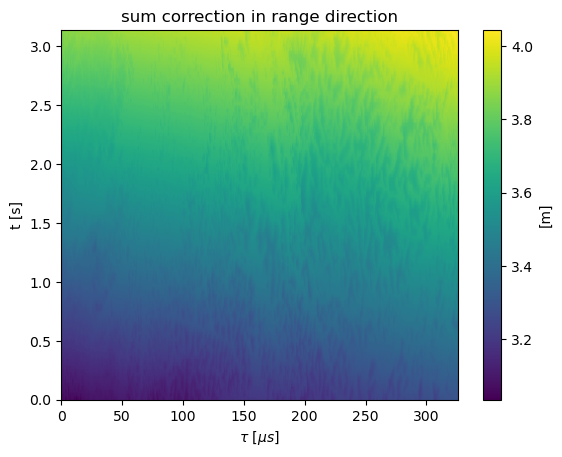

In [13]:
plt.figure()
plt.imshow(
    correction["x"],
    extent=[tau[0] * 1e6, tau[-1] * 1e6, t[0], t[-1]],
    aspect="auto",
)
plt.xlabel(r"$\tau\ [\mu s]$")
plt.ylabel("t [s]")
plt.colorbar().set_label("[{}]".format(correction["unit"]))
plt.title("{} correction in range direction".format(correction["name"]))

## Collect data statistics

**NOTE**: statistics are also available in the XML annotation file included in the S1-ETAD product

In [14]:
import pandas as pd

### Initialize dataframes

In [15]:
x_corrections_names = [
    "tropospheric",
    "ionospheric",
    "geodetic",
    "doppler",
    "sum",
]
xcols = [("", "bIndex"), ("", "t")] + [
    (cname, name)
    for cname in x_corrections_names
    for name in ("min", "mean", "std", "max")
]
xcols = pd.MultiIndex.from_tuples(xcols)
xstats_df = pd.DataFrame(columns=xcols, dtype=np.float64)

y_corrections_names = ["geodetic", "bistatic", "fmrate", "sum"]
ycols = [("", "bIndex"), ("", "t")] + [
    (cname, name)
    for cname in y_corrections_names
    for name in ("min", "mean", "std", "max")
]
ycols = pd.MultiIndex.from_tuples(ycols)
ystats_df = pd.DataFrame(columns=ycols, dtype=np.float64)

### Collect statistics

In [16]:
xrows = []
yrows = []

for swath in product:
    for burst in swath:
        az, _ = burst.get_burst_grid()
        t = np.mean(az[[0, -1]])

        # range
        row = {("", "bIndex"): burst.burst_index, ("", "t"): t}
        for name in x_corrections_names:
            data = burst.get_correction(name, meter=True)
            row[(name, "min")] = data["x"].min()
            row[(name, "mean")] = data["x"].mean()
            row[(name, "std")] = data["x"].std()
            row[(name, "max")] = data["x"].max()
        xrows.append(row)

        # azimuth
        row = {("", "bIndex"): int(burst.burst_index), ("", "t"): t}
        for name in y_corrections_names:
            # NOTE: meter is False in this case due to a limitation of the
            # current implementation
            data = burst.get_correction(name, meter=True)
            row[(name, "min")] = data["y"].min()
            row[(name, "mean")] = data["y"].mean()
            row[(name, "std")] = data["y"].std()
            row[(name, "max")] = data["y"].max()
        yrows.append(row)

xstats_df = pd.DataFrame(xrows, columns=xcols, dtype=np.float64)
ystats_df = pd.DataFrame(yrows, columns=ycols, dtype=np.float64)

### Inspect results

#### Correction statistics in range direction

In [17]:
xstats_df.head()

tropospheric                               ionospheric  \
  bIndex          t          min      mean       std       max         min   
0    1.0   1.568915     2.991868  3.125494  0.051849  3.247490    0.287995   
1    4.0   4.325513     2.968199  3.121315  0.058543  3.239469    0.287955   
2    7.0   7.082111     2.953548  3.106764  0.066205  3.239229    0.287941   
3   10.0   9.838710     2.951492  3.097788  0.059333  3.234565    0.287908   
4   13.0  12.595308     2.946268  3.086150  0.063749  3.230967    0.287858   

                                 ...  geodetic             doppler            \
       mean       std       max  ...       std       max       min      mean   
0  0.296082  0.004669  0.304159  ...  0.002253  0.130591 -0.392571 -0.000340   
1  0.296054  0.004664  0.304149  ...  0.002250  0.130647 -0.391074 -0.000983   
2  0.296030  0.004660  0.304127  ...  0.002246  0.130691 -0.390572 -0.000135   
3  0.295998  0.004667  0.304083  ...  0.002248  0.130748 -0.390581  0.000236   
4  0.295965  0.004664  0.304046  ...  0.002246  0.130800 -0.390005  0.000818   

                            sum                                
        std       max       min      mean       std       max  
0  0.223336  0.393251  3.035098  3.557500  0.228950  4.043201  
1  0.222059  0.388200  3.019752  3.552707  0.234305  4.047338  
2  0.222517  0.390753  2.998921  3.539033  0.236990  4.031289  
3  0.222655  0.391716  2.995706  3.530451  0.234525  4.023035  
4  0.222826  0.392551  2.996350  3.519417  0.235051  4.016111  

[5 rows x 22 columns]

#### Maximum value of corrections in range direction

In [18]:
xstats_df.abs().max()

              bIndex    28.000000
              t         26.378299
tropospheric  min        3.394855
              mean       3.554976
              std        0.081620
              max        3.705028
ionospheric   min        0.321480
              mean       0.330572
              std        0.005515
              max        0.339645
geodetic      min        0.123262
              mean       0.127102
              std        0.002358
              max        0.131108
doppler       min        0.470995
              mean       0.003383
              std        0.269357
              max        0.475423
sum           min        3.431760
              mean       4.005704
              std        0.286521
              max        4.595461
dtype: float64

#### Correction statistics in azimuth direction

In [19]:
ystats_df.head()

geodetic                                bistatic  \
  bIndex          t       min      mean       std       max       min   
0    1.0   1.568915  0.000086  0.000235  0.000078  0.000377 -3.432131   
1    4.0   4.325513  0.000103  0.000252  0.000078  0.000394 -3.432070   
2    7.0   7.082111  0.000121  0.000270  0.000078  0.000411 -3.432010   
3   10.0   9.838710  0.000139  0.000287  0.000079  0.000430 -3.431949   
4   13.0  12.595308  0.000156  0.000305  0.000079  0.000447 -3.431887   

                                   fmrate                                \
       mean       std       max       min      mean       std       max   
0 -2.875080  0.322415 -2.318029 -0.231449 -0.000281  0.044394  0.172403   
1 -2.875029  0.322409 -2.317988 -0.216776  0.002960  0.036497  0.189662   
2 -2.874978  0.322403 -2.317947 -0.182971  0.002239  0.042057  0.203343   
3 -2.874927  0.322397 -2.317906 -0.216336  0.001052  0.046356  0.267493   
4 -2.874876  0.322392 -2.317865 -0.233642 -0.002473  0.040933  0.156730   

        sum                                
        min      mean       std       max  
0 -3.914210 -3.214748  0.331061 -2.558306  
1 -3.872442 -3.211433  0.323444 -2.546432  
2 -3.916885 -3.212079  0.329247 -2.462662  
3 -3.921901 -3.213192  0.320566 -2.477026  
4 -3.964584 -3.216642  0.326327 -2.504485

#### Maximum value of corrections in azimuth direction

In [20]:
ystats_df.abs().max()

          bIndex    28.000000
          t         26.378299
geodetic  min        0.000768
          mean       0.000906
          std        0.000082
          max        0.001040
bistatic  min        3.432131
          mean       2.875080
          std        0.381417
          max        2.318029
fmrate    min        0.294991
          mean       0.013260
          std        0.064609
          max        0.278755
sum       min        3.999128
          mean       3.227354
          std        0.391009
          max        2.642278
dtype: float64

### Plot

<Figure size 640x480 with 0 Axes>

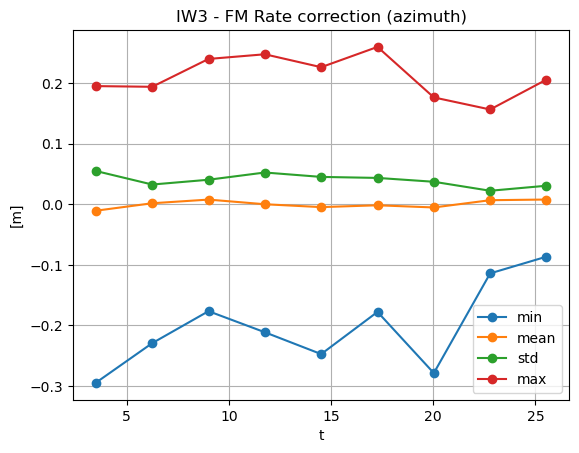

In [21]:
iw3 = product["IW3"]
iw3_df = ystats_df[ystats_df[("", "bIndex")].isin(iw3.burst_list)]

t = iw3_df[("", "t")]
fmrate_df = iw3_df.loc[:, "fmrate"]
fmrate_df.insert(0, "t", t)
fmrate_df = fmrate_df.sort_values(by="t")

plt.figure()
fmrate_df.plot(x="t", style="o-")
plt.ylabel("t [s]")
plt.ylabel("[m]")
plt.title("IW3 - FM Rate correction (azimuth)")
plt.grid()

In [22]:
xstats_df.iloc[xstats_df["sum", "max"].abs().argmax()]

              bIndex    6.000000
              t         6.246334
tropospheric  min       3.379352
              mean      3.554976
              std       0.073661
              max       3.701563
ionospheric   min       0.321467
              mean      0.330548
              std       0.005226
              max       0.339589
geodetic      min       0.108477
              mean      0.111889
              std       0.001997
              max       0.115449
doppler       min      -0.470775
              mean     -0.001597
              std       0.266933
              max       0.467533
sum           min       3.364260
              mean      4.005494
              std       0.283930
              max       4.595461
Name: 20, dtype: float64

In [23]:
ystats_df.iloc[ystats_df["sum", "max"].abs().argmax()]

          bIndex    28.000000
          t         26.378299
geodetic  min        0.000242
          mean       0.000392
          std        0.000079
          max        0.000534
bistatic  min       -3.431576
          mean      -2.874615
          std        0.322362
          max       -2.317654
fmrate    min       -0.221405
          mean      -0.004832
          std        0.030318
          max        0.177377
sum       min       -3.989237
          mean      -3.218622
          std        0.329532
          max       -2.642278
Name: 9, dtype: float64

In [24]:
xstats_df.loc[xstats_df[""]["bIndex"] == 7]["sum"]

,min,mean,std,max
2,2.998921,3.539033,0.23699,4.031289


In [25]:
ystats_df.loc[ystats_df[""]["bIndex"] == 4]["sum"]

,min,mean,std,max
1,-3.872442,-3.211433,0.323444,-2.546432
